# Performance Evaluation

In the previous sections, we trained a model that can accurately predict SCA within the training samples and the overall model accuracy is 0.998 estimated through the k-fold cross-validation approach. However, we do not know how the model performs outside the training subset. To provide a more comprehensive model evaluation, and especially to test the model transferability, we provide the following two levels of assessment:
1) As the model training only needs 4000 samples, we have 96,000 samples remaining for evaluation which are actually geographically located in the same region as the training samples. We can therefore assume that this testing subset has similar spectrum and physiographic features compared with the training subset, and thus the prediction is expected to be accurate.  

2) To ensure that we have a robust model,  we would also want to know how the model performs over the entire satellite image, and across various land cover types. One challenge we usually face when working with remotely-sensed data is that there is limited high-resolution ground-truth datasets we can use as validation datasets. We have the same issue. Previous study has applied high-resolution lidar-derived SCA data as ‘ground truth’ to evaluate snow cover (Cannistra et al., 2021) given the relatively high accuracy of lidar snow depth measurement. Here, we chose to use the same dataset for SCA evaluation. Specifically, we will use the lidar-derived high-resolution snow depth data at 3-m spatial resolution provided by the Airborne Snow Observatory (ASO, Painter et al., 2016) to map SCA. The lidar snow depth dataset does not provide direct SCA information, so we will use a threshold on the snow depth data to calculate SCA. 

The ASO conducts airborne surveys for some selected watersheds in California and Colorado. The aircraft carries a lidar sensor to map snow depth based on the elevation difference between snow-on and snow-off surfaces. The uncertainty of the final snow depth product at the 3-meter resolution is unbiased with a root mean squared error (RMSE) of 8 cm ([Painter et al., 2016](https://www.sciencedirect.com/science/article/pii/S0034425716302577)). 

A previous study by Cannistra et al., 2021 used 10 cm as a threshold to convert the ASO 3-meter snow depth data into a binary SCA map. If the snow depth is deeper than 10 cm, the pixel is classified as a snow pixel; otherwise, the pixel is a no-snow pixel. While using different thresholds will result in different SCA maps, we find that using a threshold between 8-10 cm gives the best agreement between planet SCA and ASO snow depth derived SCA (John et al., 2022, in review). So, we follow Cannistra et al., 2021 and apply 10 cm to derive SCA from ASO snow depth.

The left figure below shows the spatial distribution of snow depth for the study domain, and the right figure shows the distribution of binary snow-covered areas. The white regions represent ASO SCA.


In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

dir_aso = './data/ASO/ASO_3M_SD_USCATE_20180528_clip.tif'
raso = rasterio.open(dir_aso,'r').read()
raso = np.where(raso[0,:,:] < 0, np.nan, raso)

th = 0.1 # using 10 cm threshold
raso_binary = np.where(raso >= 0.1, 1, 0) # if the SD is higher than 10 cm, then snow; otherwise, no-snow

fig, axs = plt.subplots(1,2,figsize=(16,6))
im1 = axs[0].imshow(raso[0,:,:],cmap = 'Blues',vmin = 0, vmax = 5)
axs[0].set_title('ASO snow depth', fontsize=16)
fig.colorbar(im1, ax = axs[0], label = 'snow depth (meter)', extend = 'max')

im2 = axs[1].imshow(raso_binary[0,:,:], cmap = 'gray', interpolation = 'none')
axs[1].set_title('ASO snow cover (TH = 10 cm)', fontsize=16)

RasterioIOError: ./data/ASO/ASO_3M_SD_USCATE_20180528_clip.tif: No such file or directory

The following five evaluation metrics are used to represent model prediction accuracy:

$$ Precision = TP÷( TP + FP) $$
$$ Recall = TP ÷(TP + FN) $$

$$ F1 = 2 * Precision * Recall ÷(Precision + Recall) $$

$$ Balanced\;accuracy = TP/(TP+FN)+ TN/(TN+FP)÷ 2 $$ 

$$ Accuracy = (TP + TN)÷(TP + TN+ FP + FN) $$


Where TP, TN, FP, FN are true positive, true negative, false positive, and false negative, respectively.

#### 6.1 Testing subset model performance
We run the ‘model.predict()’ to get the snow cover prediction, where the ‘model’ is the SCA mapping model we trained in previous sections. We can use the code below to load the saved model from the directory:

In [ ]:
import joblib

dir_model = "./models/random_forest_SCA_binary.joblib"
# load model
model = joblib.load(dir_model)

Then, we calculate the five evaluation metrics using ‘calculate_metrics()’ which is a custom function we generated to evaluate model performance. 

In [ ]:
# read model input features and labels 
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data/samples/sample_100K.csv', index_col = False)
print("Sample dimentions:".format(), data.shape)
print(data.head())
X = data[['blue','green','red','nir']]
y = data['label']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.96,random_state=1)

In [ ]:
from functions_book_chapter_SCA import * 

df = pd.DataFrame()
df['obs'] = y_test
df['predict'] = model.predict(X_test)

# Cross-tabulate predictions
print(pd.crosstab(df['obs'], df['predict'], margins=True))
print(calculate_metrics(df))


predict      0      1    All
obs                         
0        54498     65  54563
1          116  41321  41437
All      54614  41386  96000
   precision    recall        f1  balanced_accuracy  accuracy
0   0.998429  0.997201  0.997815           0.998005  0.998115


From the results printed out above, the false negative is 11 within 54678 no-snow pixels, and the false positive is 22 within 41322 snow pixels. All five evaluation metrics are very close to 1, indicating the model performs very well in the remaining 96,000 testing samples, which is not very surprising as the pixels within the testing subset are located close to the training samples and also have similar spectrum features.
#### 6.2 Image wide model performance 
Now, let’s look at how the model performs across the entire image using the following steps. Firstly, we collect the four bands’ surface reflectance over the entire image, and then we apply a custom python function ‘run_sca_prediction()’ to predict SCA. Finally, we save the SCA image to ‘dir_our’ directory.


In [ ]:
dir_raster = './data/planet/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif'
dir_out = './data/SCA/'
nodata_flag = 9
run_sca_prediction(dir_raster, dir_out, nodata_flag, model)

Start to predict: 20180528_181110_1025_3B_AnalyticMS_SR_clip.tif
Image dimension: (4, 4722, 8920)
Save SCA map to:  ./data/SCA/20180528_181110_1025_3B_AnalyticMS_SR_clip_SCA.tif


We display the original Planet false-color image (left) and the predicted SCA map (right) in the figure below. Based on our visual examination, the model predicts SCA precisely and captures the spatial distribution of snow very well. Next, we will compare this Planet SCA with the validation data set – ASO SCA.


<AxesSubplot:title={'center':'Planet Snow Cover'}>

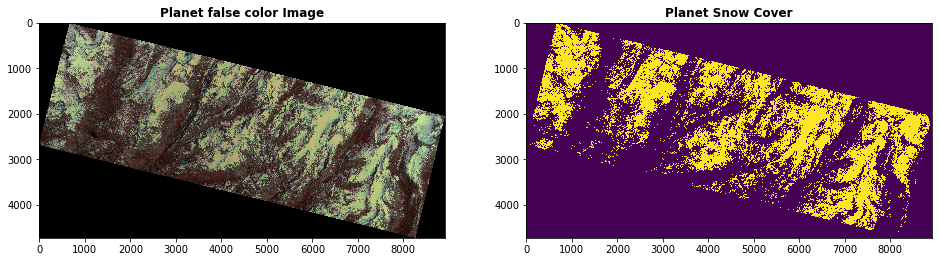

In [ ]:
dir_planet = './data/planet/20180528_181110_1025_3B_AnalyticMS_SR_clip.tif'
r_na_flag = rasterio.open(dir_planet, 'r').read()
r_planet = rasterio.open(dir_planet, 'r').read([4,3,2])/10000

dir_sca = './data/SCA/20180528_181110_1025_3B_AnalyticMS_SR_clip_SCA.tif'
r_sca = rasterio.open(dir_sca, 'r')

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (16,4))
show(r_planet, ax= ax1, cmap='jet', interpolation = 'none',title = 'Planet false color Image')
show(r_sca.read().squeeze(), ax= ax2, interpolation = 'none',title = 'Planet Snow Cover')


To compare the ASO SCA and Planet SCA to the same extent, we firstly read data within the same extent as shown by the yellow outline in the figure below. Because the ASO snow depth product should exclude water bodies and glaciers, we apply the waterbody dataset (data downloaded from [NHDPlus](https://www.epa.gov/waterdata/nhdplus-national-hydrography-dataset-plus#:~:text=National%20Hydrography%20Dataset%20Plus%20(NHDPlus,with%20the%20U.S.%20Geological%20Survey))) and glacier dataset (data downloaded from [Randolph Glacier Inventory 6.0](https://www.glims.org/RGI/rgi60_dl.html)) to mask out those areas.


In [ ]:
dir_planet_ext = './data/GIS/extent/CATE_20180528_181110_img_ext.shp'
with fiona.open(dir_planet_ext, "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]
    
dir_aso = "./data/ASO/ASO_3M_SD_USCATE_20180528_binary_clip.tif"
with rasterio.open(dir_aso,'r') as src:
    r_aso = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    
dir_pred = './data/SCA/20180528_181110_1025_3B_AnalyticMS_SR_clip_SCA.tif'
with rasterio.open(dir_pred,'r') as src:
    r_predict = rasterio.mask.mask(src, shapes, crop=True, filled = False)

dir_watermask = './data/mask/waterbody_TB_UTM11_clip.tif'
with rasterio.open(dir_watermask,'r') as src:
    r_watermask = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    
dir_glaciermask = './data/mask/02_rgi60_WesternCanadaUS_hypso_TB_clip.tif'
with rasterio.open(dir_glaciermask,'r') as src:
    r_glaciermask = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    


In [ ]:
df = pd.DataFrame()
df['predict'] = r_predict[0].ravel()
df['obs'] = r_aso[0].ravel()
df['watermask'] = r_watermask[0].ravel()
df['glaciermask'] = r_watermask[0].ravel()

# remove NA data region, water bodies, and glaciers 
df_mask = df[(df.predict >= 0) & (df.watermask != 0) & (df.glaciermask != 0)]
# print(df)

print("overall model performance:")
print(calculate_metrics(df_mask))

overall model performance:
   precision    recall        f1  balanced_accuracy  accuracy
0   0.889245  0.849336  0.868833           0.885938  0.891596


The result shows that, overall, 89% of the pixels are classified accurately with the f1 value of 0.87. The model has fewer false-positive predictions than false negative predictions as the precision value (0.89) is slightly higher than the recall value (0.85), indicating a small overall underestimation in SCA modeling. 
#### 6.3 Model performance in open versus forested areas
To explore the potential reasons that explain the mismatch between ASO SCA and Planet SCA, we divide the entire domain into two categories: open areas and forested areas. We use a 3-meter canopy height model dataset provided by ASO. Inc to classify the domain into open and forested areas. If the pixel has a tree height value higher than 1 meter, then this pixel is classified as forest; otherwise, the pixel is classified as open. 

In [ ]:
file_landcover = './data/ASO/ASO_3M_CHM_USCATB_20140827_binary_clip.tif' # 1 - forest, 0 open area
with rasterio.open(file_landcover,'r') as src:
    r_landcover = rasterio.mask.mask(src, shapes, crop=True, filled = False)
    
df['landcover'] = r_landcover[0].ravel()

df_mask = df[(df.predict >= 0) & (df.watermask != 0) & (df.glaciermask != 0)]
df_open = df_mask[df_mask.landcover == 0]
print("Model performance in open areas:")
print(calculate_metrics(df_open))

df_forest = df_mask[df_mask.landcover == 1]
print("Model performance in forested areas:")
print(calculate_metrics(df_forest))

Model performance in open areas:
   precision    recall        f1  balanced_accuracy  accuracy
0   0.891434  0.897947  0.894678           0.899603  0.899687
Model performance in forested areas:
   precision    recall        f1  balanced_accuracy  accuracy
0   0.767677  0.189074  0.303419           0.588665   0.85215


The results show a difference in model accuracy between open and forested areas. For the open areas, the overall model accuracy is 90%, with very similar precision (0.89) and recall (0.90) values, indicating similar false positive and false negative predictions. However, the overall model accuracy for the forested area is only 85%, with relatively high precision (0.77) and an extremely low recall (0.19), indicating much higher false-negative predictions than false positive. The main reason for the high false-negative in forest areas is that Planet uses optical sensors which cannot penetrate canopy cover to get underneath snow cover information while ASO uses a lidar sensor that can penetrate the canopy.



To get a close look at the difference between ASO SCA and Planet SCA, we select two example sites: A and B. Site A is in open terrain with half of the area in a shaded valley and Site B is in a dense forest. 

The model accurately predicts Planet SCA for the open areas in Site A. Even for the shaded terrain where snow and all other land surfaces have low reflectance, the model precisely captured the snow cover with only a small underestimation over the northwest corner. ASO estimates larger SCA in the shaded areas than Planet, but it slightly underestimates SCA in open areas over the southeast corner. 

For Site B, ASO and Planet show significant differences over dense forests. Planet well captures SCA over forest gaps although it shows slight underestimation along forest edges where the mixed pixel issue is not negligible, which is in line with our findings discussed in previous subsections.
![alt text](./data/fig/SCA_result_display.jpeg "Title")